Federated Transfer Learning for Pharma

In [32]:
#Imports
#dependencies: numpy, pandas, matplotlib, torch, datasets, transformers, onnxruntime, scipy, rdkit, tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset, DistributedSampler, SubsetRandomSampler
import torch.distributed as dist
import torch.multiprocessing as mp

from datasets import load_dataset
from transformers import AutoModel, AutoConfig, AutoTokenizer #dependent on onnxruntime

from scipy.stats import entropy
from sklearn.metrics import accuracy_score
from rdkit import Chem #dependent on rdkit
from tqdm import tqdm

import os
import pickle

from tokenization_embedding import tokenize_embed
from omniscient import LABEL, CLINTOX_CATS, TOX21_CATS, EmbeddingDataset, MLPClassifier, train, evaluate
from fedbcd import VerticalEmbeddingDataset, PartyBlock, fedbcd_sequential_train
from fedcvt import UnalignedEmbeddingDataset, fedcvt_evaluate, fedcvt_train, Classifier, AttentionEstimator, RepresentationNet


Dataset

In [2]:
#Moleculenet datasets
bbbp = pd.read_csv("data/BBBP.csv") #columns 'smiles' 'p_np'
clintox = pd.read_csv("data/clintox.csv") #columns 'smiles' 'FDA_APPROVED' 'CT_TOX'
sider = pd.read_csv("data/sider.csv") #columns 'smiles' & many others
tox21 = pd.read_csv("data/tox21.csv") #columns 'smiles' & many others
toxcast = pd.read_csv("data/toxcast_data.csv") #columns 'smiles' & many others

In [3]:
#Converting to canonical smiles

def smiles_to_canonical(smiles_string: str) -> str:
  """
  Converts a SMILES string to its canonical SMILES representation.

  Args:
    smiles_string: The input SMILES string.

  Returns:
    The canonical SMILES string, or None if the input is invalid.
  """
  mol = Chem.MolFromSmiles(smiles_string)
  if mol is not None:
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    return canonical_smiles
  else:
    return smiles_string

bbbp['smiles_can'] = bbbp['smiles'].apply(smiles_to_canonical)
bbbp_diffs = (bbbp['smiles_can'] != bbbp['smiles']).sum()
print(f'bbbp number converted = {bbbp_diffs}')

clintox['smiles_can'] = clintox['smiles'].apply(smiles_to_canonical)
clintox_diffs = (clintox['smiles_can'] != clintox['smiles']).sum()
print(f'clintox number converted = {clintox_diffs}')

sider['smiles_can'] = sider['smiles'].apply(smiles_to_canonical)
sider_diffs = (sider['smiles_can'] != sider['smiles']).sum()
print(f'sider number converted = {sider_diffs}')

tox21['smiles_can'] = tox21['smiles'].apply(smiles_to_canonical)
tox21_diffs = (tox21['smiles_can'] != tox21['smiles']).sum()
print(f'tox21 number converted = {tox21_diffs}')

toxcast['smiles_can'] = toxcast['smiles'].apply(smiles_to_canonical)
toxcast_diffs = (toxcast['smiles_can'] != toxcast['smiles']).sum()
print(f'toxcast number converted = {toxcast_diffs}')

[02:21:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] Explicit valence for atom # 6 N, 4, is greater than permitted
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] Explicit valence for atom # 6 N, 4, is greater than permitted
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] WARNING: not removing hydrogen atom without neighbors
[02:21:46] Explicit valence for atom # 11 N, 4, is greater than pe

bbbp number converted = 1914
clintox number converted = 1429


[02:21:46] Can't kekulize mol.  Unkekulized atoms: 4
[02:21:46] Can't kekulize mol.  Unkekulized atoms: 4
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] WARNING: not removing hydrogen atom without neighbors


sider number converted = 1366


[02:21:47] WARNING: not removing hydrogen atom without neighbors
[02:21:47] Explicit valence for atom # 8 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 3 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 9 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 5 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 16 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 20 Al, 6, is greater than permitted
[02:21:47] Explicit valence for atom # 0 F, 1, is greater than permitted


tox21 number converted = 300


[02:21:47] Explicit valence for atom # 2 Cl, 1, is greater than permitted
[02:21:47] Explicit valence for atom # 0 Cl, 1, is greater than permitted
[02:21:48] WARNING: not removing hydrogen atom without neighbors
[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL
[02:21:48] SMILES Parse Error: check for mistakes around position 2:
[02:21:48] FAIL
[02:21:48] ~^
[02:21:48] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL
[02:21:48] SMILES Parse Error: check for mistakes around position 2:
[02:21:48] FAIL
[02:21:48] ~^
[02:21:48] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL
[02:21:48] SMILES Parse Error: check for mistakes around position 2:
[02:21:48] FAIL
[02:21:48] ~^
[02:21:48] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL


toxcast number converted = 7203


[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL
[02:21:48] SMILES Parse Error: check for mistakes around position 2:
[02:21:48] FAIL
[02:21:48] ~^
[02:21:48] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL
[02:21:48] SMILES Parse Error: check for mistakes around position 2:
[02:21:48] FAIL
[02:21:48] ~^
[02:21:48] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL
[02:21:48] SMILES Parse Error: check for mistakes around position 2:
[02:21:48] FAIL
[02:21:48] ~^
[02:21:48] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[02:21:48] SMILES Parse Error: syntax error while parsing: FAIL
[02:21:48] SMILES Parse Error: check for mistakes around position 2:
[02:21:48] FAIL
[02:21:48] ~^
[02:21:48] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'


In [4]:
#Data exploration: dataset overlap, sequence length, sequence composition

# Put all dataframes in a dict for easier processing
datasets = {
    "bbbp": bbbp,
    "clintox": clintox,
    "sider": sider,
    "tox21": tox21,
    "toxcast": toxcast,
}

# Create one big dataframe with a source column
df_all = []

for name, df in datasets.items():
    temp = df[["smiles_can"]].copy()
    temp["dataset"] = name
    df_all.append(temp)

df_all = pd.concat(df_all, ignore_index=True)

# Count total occurrences of each SMILES across all datasets
counts = df_all["smiles_can"].value_counts().rename("count")

# Create indicator columns for which dataset(s) each SMILES appears in
presence = (df_all
            .drop_duplicates()
            .pivot_table(index="smiles_can",
                         columns="dataset",
                         aggfunc=lambda x: 1,
                         fill_value=0))

# Flatten column index if needed
presence.columns.name = None

# Combine count + presence indicators
result = pd.concat([counts, presence], axis=1).reset_index()

# Rename first column
result = result.rename(columns={"index": "smiles_can"})

result.head()

,smiles_can,count,bbbp,clintox,sider,tox21,toxcast
0,FAIL,15,0,0,0,0,1
1,CC(=O)Oc1ccccc1C(=O)O,6,1,1,1,1,1
2,O=c1[nH]cc(F)c(=O)[nH]1,6,1,1,1,1,1
3,O=C1NC(=O)C(c2ccccc2)(c2ccccc2)N1,6,1,1,1,1,1
4,CCCN(CCC)CCc1cccc2c1CC(=O)N2,6,1,0,1,1,1


6878
13049


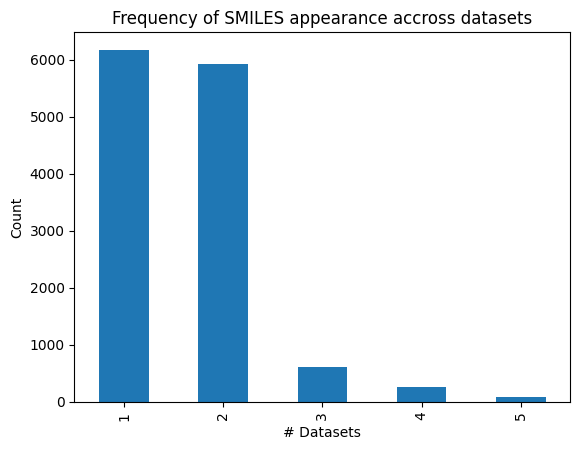

In [5]:
#Bar chart of distribution of number of datasets sequences found in

result['ndatasets'] = result['bbbp'] + result['clintox'] + result['sider'] + result['tox21'] + result['toxcast']

print((result['ndatasets'] > 1).sum())
print(len(result))

result['ndatasets'].value_counts().plot.bar(title='Frequency of SMILES appearance accross datasets', xlabel='# Datasets', ylabel='Count')
plt.show()


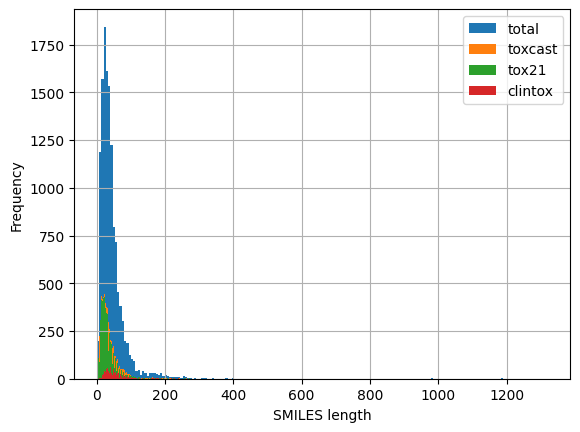

In [6]:
#Chart of SMILES length distribution

result['len'] = result['smiles_can'].apply(len)
result['len'].hist(bins=200, label='total')
result[result['toxcast'] == 1]['len'].hist(bins=200, label='toxcast')
result[result['tox21'] == 1]['len'].hist(bins=200, label='tox21')
result[result['clintox'] == 1]['len'].hist(bins=200, label='clintox')
plt.xlabel('SMILES length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

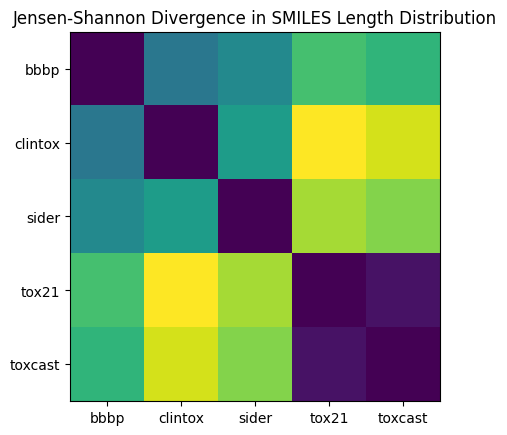

In [7]:
#Jensen-Shannon heatmap for SMILES length distribution divergence between datasets 

def jensen_shannon(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

len_shannon = np.zeros([5,5])
bins = np.arange(0, 400, 50)
datasets_lst = ['bbbp', 'clintox', 'sider', 'tox21', 'toxcast']
for i, ds1 in enumerate(datasets_lst):
  for j, ds2 in enumerate(datasets_lst):
    l1 = result[result[ds1] == 1]['len']
    l2 = result[result[ds2] == 1]['len']
    all_lengths = np.concatenate([l1, l2])
    # Use integer bins for molecule lengths
    bins = np.arange(all_lengths.min(), all_lengths.max() + 2)  # +2 because histogram is upper-exclusive
    # Histogram counts
    hist1, _ = np.histogram(l1, bins=bins)
    hist2, _ = np.histogram(l2, bins=bins)
    # Convert counts → probability distributions
    p = hist1 / hist1.sum()
    q = hist2 / hist2.sum()
    len_shannon[i, j] = jensen_shannon(p, q) #KL is asymmetrical, which is why we need whole grid

fig, ax = plt.subplots()
ax.imshow(len_shannon, cmap='viridis')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(datasets_lst)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(datasets_lst)
plt.title('Jensen-Shannon Divergence in SMILES Length Distribution')
plt.show()

In [8]:
#IF already have embeddings
#Loading embeddings

embeddings = np.genfromtxt('embeddings.csv', delimiter=',')
print(embeddings.shape)

(13049, 384)


In [14]:
#Otherwise run this and then the previous cell
#NOTE: may not work with newer python versions

tokenize_embed(result)

In [15]:
#Prepping dataset(s) for one party learning

train_setting = 'clintox_tox21' #clintox or clintox_tox21

if train_setting == 'clintox':
  dfA = 'clintox'
  input_dim = len(CLINTOX_CATS) + 384

  #get indices of molecules in selected dataset
  selected_indices = result[dfA] > 0
  result_selected_idx = result[selected_indices].set_index("smiles_can")
  selected_df_idx = datasets[dfA].drop_duplicates(subset=['smiles_can'], keep='first').set_index("smiles_can")
  selected_df_reordered = selected_df_idx.reindex(result_selected_idx.index).reset_index()
  embedding = embeddings[selected_indices, :]

  dataset = EmbeddingDataset(selected_df_reordered, None, embedding, None)

elif train_setting == 'clintox_tox21':
  dfA = 'clintox'
  dfB = 'tox21'
  input_dim = len(CLINTOX_CATS) + len(TOX21_CATS) + 384 #number of predictor categories from clintox, tox21, and structural embedding dimensions

  #get indices of molecules in selected dataset
  selected_indices = result[dfA] > 0
  selected_indices_B = result[dfB] > 0
  #reordering A
  result_selected_idx = result[selected_indices].set_index("smiles_can")
  selected_df_idx = datasets[dfA].drop_duplicates(subset=['smiles_can'], keep='first').set_index("smiles_can")
  selected_df_reordered = selected_df_idx.reindex(result_selected_idx.index).reset_index()
  embedding = embeddings[selected_indices, :]
  #reordering B
  result_selected_idx_B = result[selected_indices_B].set_index("smiles_can")
  selected_df_idx_B = datasets[dfB].drop_duplicates(subset=['smiles_can'], keep='first').set_index("smiles_can")
  selected_df_reordered_B = selected_df_idx_B.reindex(result_selected_idx_B.index).reset_index()
  selected_df_reordered_B = selected_df_reordered_B.fillna(-1)
  embedding_B = embeddings[selected_indices_B, :]

  dataset = EmbeddingDataset(selected_df_reordered, selected_df_reordered_B, embedding, embedding_B)


One Party Learning

In [18]:
epochs = 100
lr = 1e-3

# train/val split (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

# model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPClassifier(input_dim=input_dim, hidden_dim=256, class_dim=1, dropout=0.1).to(device)

criterion = nn.BCEWithLogitsLoss()  # binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# training
train_loss_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(1, epochs+1):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 01 | Train Loss: 0.3650 | Val Loss: 0.2386 | Val Acc: 0.9381
Epoch 02 | Train Loss: 0.2647 | Val Loss: 0.2345 | Val Acc: 0.9381
Epoch 03 | Train Loss: 0.2599 | Val Loss: 0.2255 | Val Acc: 0.9381
Epoch 04 | Train Loss: 0.2507 | Val Loss: 0.2259 | Val Acc: 0.9381
Epoch 05 | Train Loss: 0.2399 | Val Loss: 0.2263 | Val Acc: 0.9381
Epoch 06 | Train Loss: 0.2444 | Val Loss: 0.2249 | Val Acc: 0.9381
Epoch 07 | Train Loss: 0.2297 | Val Loss: 0.2304 | Val Acc: 0.9381
Epoch 08 | Train Loss: 0.2246 | Val Loss: 0.2192 | Val Acc: 0.9381
Epoch 09 | Train Loss: 0.2168 | Val Loss: 0.2150 | Val Acc: 0.9381
Epoch 10 | Train Loss: 0.2105 | Val Loss: 0.2137 | Val Acc: 0.9381
Epoch 11 | Train Loss: 0.2003 | Val Loss: 0.2083 | Val Acc: 0.9381
Epoch 12 | Train Loss: 0.2034 | Val Loss: 0.2184 | Val Acc: 0.9381
Epoch 13 | Train Loss: 0.2000 | Val Loss: 0.2429 | Val Acc: 0.9381
Epoch 14 | Train Loss: 0.1954 | Val Loss: 0.2202 | Val Acc: 0.9381
Epoch 15 | Train Loss: 0.1863 | Val Loss: 0.2358 | Val Acc: 0.

Horizontal Federated Learning

In [20]:
#need to store data as pickle file for this one; can't run distributed easily in notebook
# print(type(dataset))
# print(dataset.embeddings.shape)

with open('dataset.pkl', 'wb') as outp:
    pickle.dump(dataset, outp, pickle.HIGHEST_PROTOCOL)
    print('finished pickling.')

finished pickling.


Note: running the distributed code is often finnickey--if having problems, suggest using Google Colab. Works in that environment.

In [27]:
!torchrun --nproc_per_node=2 --standalone horizontal.py --dataset dataset.pkl --input_dim 397

FedBCD

In [31]:
if __name__ == "__main__":
    #experiment with these
    gets_embeddings = [1,1] #whether clintox and tox21 datasets each have molecular sequence embeddings to learn off of as well
    q_local = 5

    # train FedBCD
    partyA_model, partyB_model = fedbcd_sequential_train(
        selected_df_reordered, selected_df_reordered_B, embedding, embedding_B, gets_embeddings,
        epochs=100//q_local, batch_size=32, lr=1e-3, q_local=q_local, hidden_dim=256
    )

Epoch 01 | train_loss=0.2358 | val_loss=0.3968 | val_acc=0.9072
Epoch 02 | train_loss=0.2425 | val_loss=0.3622 | val_acc=0.9072
Epoch 03 | train_loss=0.1854 | val_loss=1.1288 | val_acc=0.9072
Epoch 04 | train_loss=0.1615 | val_loss=0.3340 | val_acc=0.9072
Epoch 05 | train_loss=0.1438 | val_loss=0.2608 | val_acc=0.9072
Epoch 06 | train_loss=0.1259 | val_loss=0.3870 | val_acc=0.9072
Epoch 07 | train_loss=0.1258 | val_loss=0.4246 | val_acc=0.8660
Epoch 08 | train_loss=0.1107 | val_loss=0.2381 | val_acc=0.9072
Epoch 09 | train_loss=0.0817 | val_loss=1.0869 | val_acc=0.9072
Epoch 10 | train_loss=0.0860 | val_loss=0.1904 | val_acc=0.8969
Epoch 11 | train_loss=0.0632 | val_loss=0.2907 | val_acc=0.8660
Epoch 12 | train_loss=0.0471 | val_loss=0.3081 | val_acc=0.9072
Epoch 13 | train_loss=0.0367 | val_loss=0.2259 | val_acc=0.9072
Epoch 14 | train_loss=0.0314 | val_loss=0.3055 | val_acc=0.9175
Epoch 15 | train_loss=0.0265 | val_loss=0.2115 | val_acc=0.9072
Epoch 16 | train_loss=0.0185 | val_loss=

FedCVT

In [33]:
#FedCVT
feddataset = UnalignedEmbeddingDataset(selected_df_reordered, selected_df_reordered_B, embedding, embedding_B)
embA_train, embB_train, labels_train = feddataset.get_train()
embA_val, embB_val, labels_val = feddataset.get_val(aligned_only=True)

(1465, 4) (7831, 15) (1465, 384) (7831, 384)
<class 'torch.Tensor'> <class 'list'> <class 'list'>


In [34]:
models = fedcvt_train(
    A_data=embA_train,  # (N_A, dim_A)
    B_data=embB_train,  # (N_B, dim_B)
    A_labels=labels_train,       # (N_A, 1)
    n_aligned=int(feddataset.n_aligned * 0.8),
    epochs=100,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Evaluate
h_A_u, h_A_c, h_B_u, h_B_c, f_A, f_B, f_AB = models
accuracy, preds = fedcvt_evaluate(
    h_A_u, h_A_c, h_B_u, h_B_c, f_AB,
    embA_val, embB_val, labels_val
)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/100 | Loss: 1.1751
Epoch 10/100 | Loss: 0.4321
Epoch 20/100 | Loss: 0.2030
Epoch 30/100 | Loss: 0.1374
Epoch 40/100 | Loss: 0.2105
Epoch 50/100 | Loss: 0.1651
Epoch 60/100 | Loss: 0.1173
Epoch 70/100 | Loss: 0.1194
Epoch 80/100 | Loss: 0.1049
Epoch 90/100 | Loss: 0.2157
Epoch 100/100 | Loss: 0.2106
Test Accuracy: 0.9691
